In [8]:
import pandas as pd
gstock_data = pd.read_csv('lstm_data.csv')
gstock_data.head()

,Date,Open,High,Low,Close,Volume
0,12/19/2016,790.219971,797.659973,786.270020,794.200012,1225900
1,12/20/2016,796.760010,798.650024,793.270020,796.419983,925100
2,12/21/2016,795.840027,796.676025,787.099976,794.559998,1208700
3,12/22/2016,792.359985,793.320007,788.580017,791.260010,969100
4,12/23/2016,790.900024,792.739990,787.280029,789.909973,623400


In [10]:
# Retain only the necessary columns
gstock_data = gstock_data[['Date', 'Open', 'Close']] 

# Convert 'date' column to datetime after extracting the date part
gstock_data['Date'] = pd.to_datetime(gstock_data['Date'].apply(lambda x: x.split()[0]))

# Set 'date' as the index
gstock_data.set_index('Date', drop=True, inplace=True)

# Display the first few rows of the DataFrame
gstock_data.head()


C:\Users\rishi\AppData\Local\Temp\ipykernel_17148\1937014384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gstock_data['Date'] = pd.to_datetime(gstock_data['Date'].apply(lambda x: x.split()[0]))


,Open,Close
Date,,
2016-12-19,790.219971,794.200012
2016-12-20,796.760010,796.419983
2016-12-21,795.840027,794.559998
2016-12-22,792.359985,791.260010
2016-12-23,790.900024,789.909973


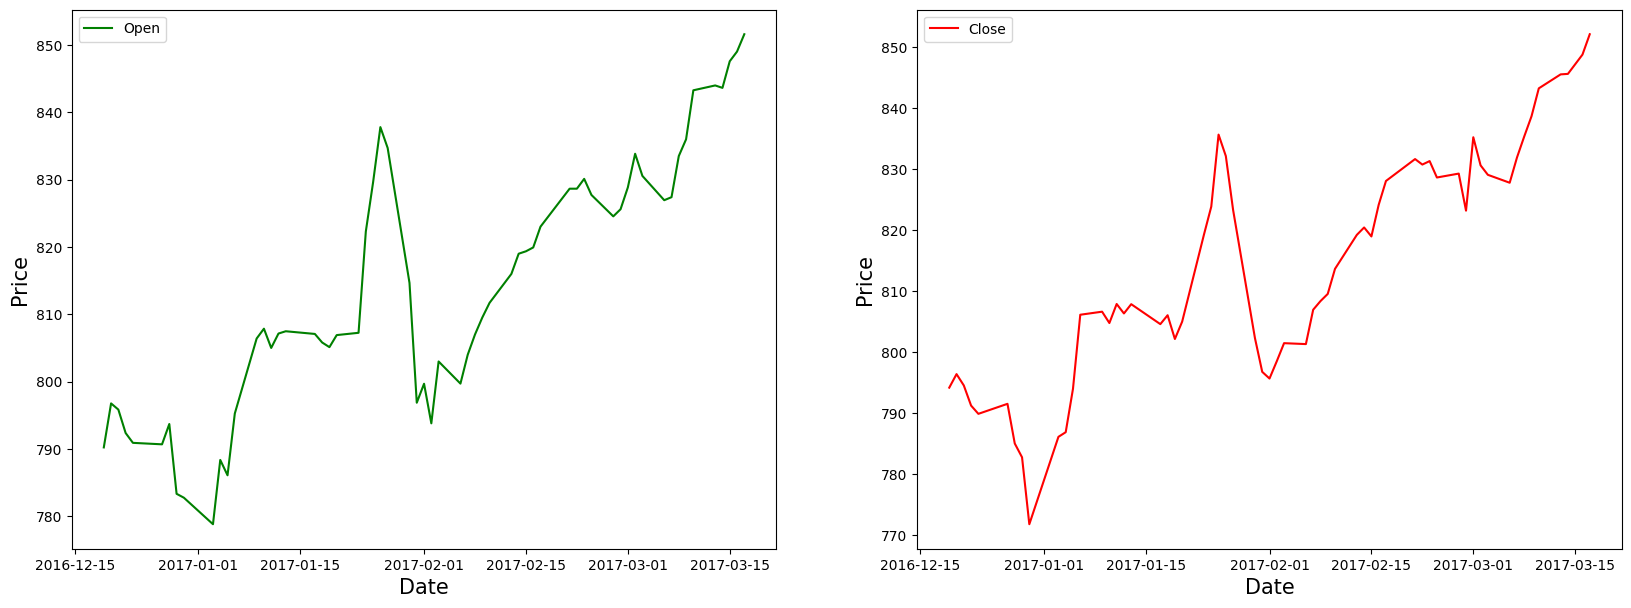

In [12]:
import matplotlib.pyplot as plt # Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Plot the 'open' prices on the first subplot
ax[0].plot(gstock_data['Open'], label='Open', color='green')
ax[0].set_xlabel('Date', size=15)
ax[0].set_ylabel('Price', size=15)
ax[0].legend()

# Plot the 'close' prices on the second subplot
ax[1].plot(gstock_data['Close'], label='Close', color='red')
ax[1].set_xlabel('Date', size=15)
ax[1].set_ylabel('Price', size=15)
ax[1].legend()

# Display the plot
plt.show()


In [13]:
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
gstock_data [gstock_data .columns] = Ms.fit_transform(gstock_data )

training_size = round(len(gstock_data ) * 0.80)

train_data = gstock_data [:training_size]
test_data  = gstock_data [training_size:]

In [21]:
print(train_data.shape)

(49, 2)


In [25]:
import numpy as np
def create_sequence(dataset):
    sequences = []
    labels = []
    start_idx = 0

    # Iterate through the dataset to create sequences and labels
    for stop_idx in range(10, len(dataset)):
        sequences.append(dataset.iloc[start_idx:stop_idx].values)  # Extract sequence
        labels.append(dataset.iloc[stop_idx])                     # Extract label
        start_idx += 1

    # Convert sequences and labels to numpy arrays
    return (np.array(sequences), np.array(labels))

# Use the function to create sequences for training and testing data
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)


In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [27]:
print(train_label.shape)  # Should output something like (num_samples, timesteps, num_features)


(39, 2)


In [35]:
print(test_data.shape)

(12, 2)


In [28]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

C:\Users\rishi\Python\Python3119\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,902 (120.71 KB)

 Trainable params: 30,902 (120.71 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)
test_predicted = model.predict(test_seq)
test_inverse_predicted = Ms.inverse_transform(test_predicted)

Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0178 - mean_absolute_error: 0.1108 - val_loss: 0.0829 - val_mean_absolute_error: 0.2871
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0177 - mean_absolute_error: 0.1071 - val_loss: 0.0733 - val_mean_absolute_error: 0.2700
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0192 - mean_absolute_error: 0.1103 - val_loss: 0.0711 - val_mean_absolute_error: 0.2658
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0188 - mean_absolute_error: 0.1072 - val_loss: 0.0714 - val_mean_absolute_error: 0.2665
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0171 - mean_absolute_error: 0.1054 - val_loss: 0.0748 - val_mean_absolute_error: 0.2728
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0175 - mean_absolute_error: 0.1072 - val_loss: 0.0752 - val_mean_absolute_error: 0.2734
Epoch 7/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0179 - mean_absolute_error: 0.1068 - val_loss: 0.0690 - va

In [36]:
print(test_predicted.shape)

(2, 2)


In [37]:
# Generate predictions for test data
test_predicted = model.predict(test_seq)

# Ensure predicted values are inverse-transformed correctly
test_inverse_predicted = Ms.inverse_transform(test_predicted)

# Align the actual test data with predictions
# Use only the portion of the data corresponding to the labels
aligned_actual = gstock_data.iloc[training_size + 10:].copy()  # Align with sequence labels
aligned_actual = aligned_actual.iloc[:len(test_inverse_predicted)]  # Ensure alignment

# Create a DataFrame for predictions
predicted_df = pd.DataFrame(test_inverse_predicted, 
                            columns=['open_predicted', 'close_predicted'], 
                            index=aligned_actual.index)

# Concatenate actual and predicted data
gs_slic_data = pd.concat([aligned_actual, predicted_df], axis=1)

# Inverse transform the actual values for readability
gs_slic_data[['Open', 'Close']] = Ms.inverse_transform(gs_slic_data[['Open', 'Close']])

# Check the final DataFrame
print(gs_slic_data.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
                  Open       Close  open_predicted  close_predicted
Date                                                               
2017-03-16  849.030029  848.780029      829.751465       827.544556
2017-03-17  851.609985  852.119995      829.708130       827.541931


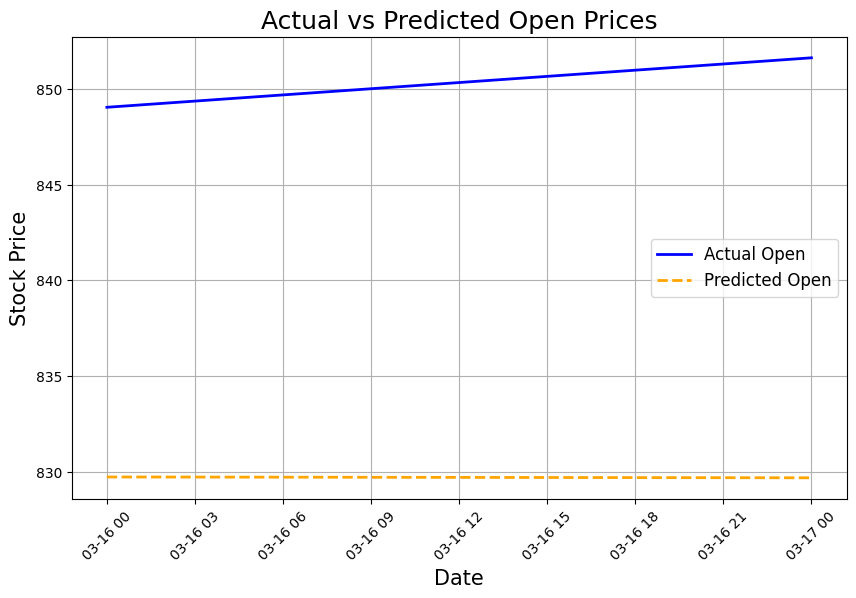

In [42]:
import matplotlib.pyplot as plt

# Plot the actual and predicted open prices for the available data
plt.figure(figsize=(10, 6))
plt.plot(gs_slic_data.index, gs_slic_data['Open'], label='Actual Open', color='blue', linewidth=2)
plt.plot(gs_slic_data.index, gs_slic_data['open_predicted'], label='Predicted Open', color='orange', linestyle='--', linewidth=2)

# Add labels, title, legend, and improve x-axis readability
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)
plt.title('Actual vs Predicted Open Prices', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)

# Display the plot
plt.show()
